In [6]:
import os
import numpy as np
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [7]:
# Load the saved model
model = tf.keras.models.load_model('./tf-gpu/my_model_finetuned.h5')

column_names = ['image_id'] + [
    "5_o_Clock_Shadow", "Arched_Eyebrows", "Attractive", "Bags_Under_Eyes", "Bald", "Bangs",
    "Big_Lips", "Big_Nose", "Black_Hair", "Blond_Hair", "Blurry", "Brown_Hair", "Bushy_Eyebrows",
    "Chubby", "Double_Chin", "Eyeglasses", "Goatee", "Gray_Hair", "Heavy_Makeup", "High_Cheekbones",
    "Male", "Mouth_Slightly_Open", "Mustache", "Narrow_Eyes", "No_Beard", "Oval_Face", "Pale_Skin",
    "Pointy_Nose", "Receding_Hairline", "Rosy_Cheeks", "Sideburns", "Smiling", "Straight_Hair",
    "Wavy_Hair", "Wearing_Earrings", "Wearing_Hat", "Wearing_Lipstick", "Wearing_Necklace",
    "Wearing_Necktie", "Young"
]

# Define a function to preprocess the input image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))  # Resize the image
    img_array = image.img_to_array(img)  # Convert the image to a numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return img_array

# Define categories
categories = ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']

#definition to get predictions for images in specified dir
def update_predictions(image_directory, verbose=False):
    # Create an empty list to store the results for 'Blond hair' and 'Young'
    results = []
    images_without_blond_hair = []  
    images_not_young = []  
    
    # Loop over each image in the directory and make predictions
    for img_filename in os.listdir(image_directory):
        if img_filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(image_directory, img_filename)
            
            # Preprocess the image
            img = preprocess_image(img_path)
            
            # Get predictions from the model
            predictions = model.predict(img,verbose=0)  # This will be a 2D array (1, 5), corresponding to the 5 categories
            
            # Translate predictions to dataframe values
            young_pred = predictions[0][4]  # Prediction for 'Young'
            
            # Determine Male and Young values based on threshold
            young_value = 1 if young_pred > 0.5 else -1
            
            # Find the index of the highest hair color prediction
            hair_predictions = predictions[0][:3]  # First three predictions correspond to hair colors (Black, Blond, Brown)
            max_hair_index = np.argmax(hair_predictions)  # Get the index of the highest prediction
            if max_hair_index == 1:
                blond_value = 1  # Blond hair is set to 1
            else:
                blond_value = -1
            
            # Append the prediction results to the list
            results.append([img_filename, blond_value, young_value])

            # store image paths
            if blond_value == -1:
                images_without_blond_hair.append(img_path)
            if young_value == -1:
                images_not_young.append(img_path)
                
            # Optionally print the progress if verbose=True
            if verbose:
                print(f"Processed: {img_filename} | Blond hair: {blond_value}, Young: {young_value}")
    
    # Create a DataFrame with the results
    df = pd.DataFrame(results, columns=['Image Filename', 'Blond hair', 'Young'])
    
    # Return the DataFrame with the predictions
    return df, images_without_blond_hair, images_not_young


# Function to display images in a grid (5 images per row)
def display_images(images_paths):
    # Number of images per row
    images_per_row = 5
    num_images = len(images_paths)
    
    # Calculate number of rows needed to display all images
    num_rows = math.ceil(num_images / images_per_row)
    
    # Create a figure for the grid
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * 3, num_rows * 3))
    
    # Flatten the axes array to make indexing easier
    axes = axes.flatten()
    
    # Loop over each image and display it in the grid
    for i, img_path in enumerate(images_paths):
        img = mpimg.imread(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')  # Hide axes for better display
    
    # Hide any unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    # Adjust the layout to prevent overlap
    plt.tight_layout()
    plt.show()

In [8]:
#accuracy for CelebA single transformation
#normally this is the number correct predictions made by the classifier. 
#Here the expected output for all images is "blond hair," and the classifier's prediction for each image is compared to this expected output.
# accuracy = Number of correct predictions/Total number of predictions

# Call the update_predictions function to get the DataFrame
df_filtered, CelebA_ST_images_without_blond_hair, _  = update_predictions("./celeba_Orig/reduced/images/single transformation/images", verbose=False)

# Count the number of items (rows) in the DataFrame
item_count = len(df_filtered)

# Print the count
print(f"Number of items in df_filtered: {item_count}")

# Compare the predicted attribute ('Blond_hair') with the expected attribute
correct_predictions = df_filtered['Blond hair'] == 1  
correct_count = correct_predictions.sum()  # Sum up all True values (1's)

# Print the count of correct predictions
print(f"Number of correct predictions: {correct_count}")

# Calculate accuracy
accuracy = correct_predictions.mean()

# Print the accuracy
print(f'Accuracy: {accuracy * 100:.2f}%')

#print images
#display_images(CelebA_ST_images_without_blond_hair)

Number of items in df_filtered: 1999
Number of correct predictions: 1780
Accuracy: 89.04%


In [9]:
#accuracy for FFHQ single transformation

# Call the update_predictions function to get the DataFrame
df_filtered, FFHQ_ST_images_without_blond_hair, _  = update_predictions("./ffhq/reduced/images/single transformation/images",verbose=False)

# Count the number of items (rows) in the DataFrame
item_count = len(df_filtered)

# Print the count
print(f"Number of items in df_filtered: {item_count}")

# Compare the predicted attribute ('Blond_hair') with the expected attribute
correct_predictions = df_filtered['Blond hair'] == 1  
correct_count = correct_predictions.sum()  # Sum up all True values (1's)

# Print the count of correct predictions
print(f"Number of correct predictions: {correct_count}")

# Calculate accuracy
accuracy = correct_predictions.mean()

# Print the accuracy
print(f'Accuracy: {accuracy * 100:.2f}%')

#print images
#display_images(FFHQ_ST_images_without_blond_hair)

Accuracy: 86.44%


In [10]:
#accuracy for CelebA multi transformation

# Call the update_predictions function to get the DataFrame
df_filtered,CelebA_MT_images_without_blond_hair,CelebA_MT_images_without_blond_hair = update_predictions("./celeba_Orig/reduced/images/multi transformation/images", verbose=False)

# Print the count
print(f"Number of items in df_filtered: {item_count}")

# Expected values are 1 for both "Blond hair" and "Young"
# Compare both predicted attributes ('Blond_hair' and 'Young') with the expected value
# creation of two boolean Series
correct_predictions_blond = df_filtered['Blond hair'] == 1   # Blond hair expected to be 1
correct_predictions_young = df_filtered['Young'] == 1        # Young expected to be 1

# Calculate accuracy for both Blond hair and Young being correctly predicted
correct_predictions = correct_predictions_blond & correct_predictions_young
correct_count = correct_predictions.sum()  # Sum up all True values (1's)

# Print the count of correct predictions
print(f"Number of correct predictions: {correct_count}")

# Calculate overall accuracy
accuracy = correct_predictions.mean()

# Print the accuracy
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 75.64%


In [11]:
#accuracy for ffhq multi transformation

# Call the update_predictions function to get the DataFrame
df_filtered,FFHQ_MT_images_without_blond_hair,FFHQ_MT_images_without_blond_hair = update_predictions("./ffhq/reduced/images/multi transformation/images", verbose=False)

# Print the count
print(f"Number of items in df_filtered: {item_count}")

# Expected values are 1 for both "Blond hair" and "Young"
# Compare both predicted attributes ('Blond_hair' and 'Young') with the expected value
# creation of two boolean Series
correct_predictions_blond = df_filtered['Blond hair'] == 1   # Blond hair expected to be 1
correct_predictions_young = df_filtered['Young'] == 1        # Young expected to be 1

# Calculate accuracy for both Blond hair and Young being correctly predicted
correct_predictions = correct_predictions_blond & correct_predictions_young
correct_count = correct_predictions.sum()  # Sum up all True values (1's)

# Print the count of correct predictions
print(f"Number of correct predictions: {correct_count}")

# Calculate overall accuracy -  computes the proportion of True values in the correct_predictions series
accuracy = correct_predictions.mean()

# Print the accuracy
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 70.84%


C:\Users\Gordts-De Laender\AppData\Local\Temp\ipykernel_3208\1740129419.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Transformation', y='Accuracy (%)', data=df_accuracy, palette='Blues_d')


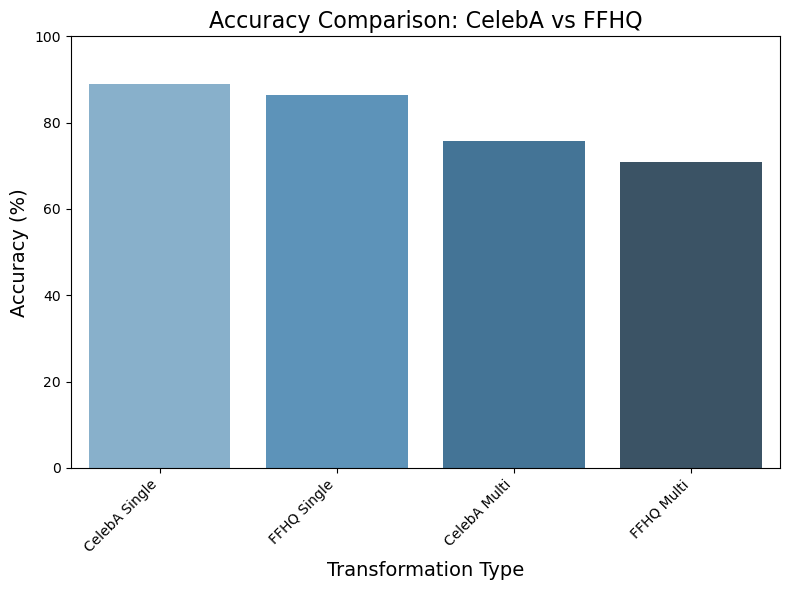

Accuracy Table:
Transformation  Accuracy (%)
 CelebA Single         89.04
   FFHQ Single         86.44
  CelebA Multi         75.64
    FFHQ Multi         70.84


In [12]:
#accuracy side by side
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Define the accuracy results
data = {
    'Transformation': ['CelebA Single', 'FFHQ Single', 'CelebA Multi', 'FFHQ Multi'],
    'Accuracy (%)': [89.04, 86.44, 75.64, 70.84]  # These should be the accuracy values you calculated
}

# Create a DataFrame
df_accuracy = pd.DataFrame(data)

# Plotting the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='Transformation', y='Accuracy (%)', data=df_accuracy, palette='Blues_d')
plt.title('Accuracy Comparison: CelebA vs FFHQ', fontsize=16)
plt.xlabel('Transformation Type', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.ylim(0, 100)  # Set y-axis limits from 0 to 100
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
plt.tight_layout()
plt.show()

# Display the table (this can be included in the paper if needed)
print("Accuracy Table:")
print(df_accuracy.to_string(index=False))

# If you want to save the table to a file
df_accuracy.to_csv('accuracy_comparison.csv', index=False)


To do: testing generalizability qualitatively through visual inspection of the transformed images, assessing whether the generated attributes are consistent with the intended transformation (blond hair, young).

Select Random Samples + and Side-by-Side Comparison (Show the original image alongside the transformed images)
Perform Visual Consistency Score: Give each image a score from 1 to 10 based on how well the transformation matches the target attribute (blond hair, young).